<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vSVDp-ccEE5h_Tc21rCYAETyhq23CQ_zeRwmJ4zasy4HGsBWL7xhxfUDsmJbKE46aMIrYcjmVqb0QE3/embed?start=false&loop=true&delayms=5000" frameborder="0" width="960" height="569" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>

Here is the first project given to us at the General Assembly data science immersion program. We were given two databases of 2017 SAT and ACT average scores by state. We were given detailed tasks involving cleaning and exploring the data, and then told to make presentations to the College Board to suggest ways of increasing participation. This blog will be mostly a detailed desciption of my code along with my resulting presentation at the end. However, I have taken the liberty of deleting many cells that didn't really end up contributing to the final presentation as well as for the sake of readibility. 

Please keep in my that I was able to do this work after just two weeks of instruction.  

Loading in the file:

In [2]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
csv_file_act = "../data/act.csv"
csv_file_sat = "../data/sat.csv"
act = pd.read_csv(csv_file_act)
sat = pd.read_csv(csv_file_sat)

In [3]:
act.head()

,Unnamed: 0,State,Participation,English,Math,Reading,Science,Composite
0,0,National,60%,20.3,20.7,21.4,21.0,21.0
1,1,Alabama,100%,18.9,18.4,19.7,19.4,19.2
2,2,Alaska,65%,18.7,19.8,20.4,19.9,19.8
3,3,Arizona,62%,18.6,19.8,20.1,19.8,19.7
4,4,Arkansas,100%,18.9,19.0,19.7,19.5,19.4


In [4]:
sat.head()

,Unnamed: 0,State,Participation,Evidence-Based Reading and Writing,Math,Total
0,0,Alabama,5%,593,572,1165
1,1,Alaska,38%,547,533,1080
2,2,Arizona,30%,563,553,1116
3,3,Arkansas,3%,614,594,1208
4,4,California,53%,531,524,1055


In [5]:
sat.dtypes

Unnamed: 0                             int64
State                                 object
Participation                         object
Evidence-Based Reading and Writing     int64
Math                                   int64
Total                                  int64
dtype: object

The SAT dataset is all integers with the exception of Participation and State, which are strings. 

In [6]:
act.dtypes

Unnamed: 0         int64
State             object
Participation     object
English          float64
Math             float64
Reading          float64
Science          float64
Composite        float64
dtype: object

Data dictionary:

- State: state the data was taken from.

- Participation rate: number of students in that state participated in the SAT during 2017. The exact parameters for this are unclear.

- Composite/Total: average total score for either test, by state.

- Evidence-Based Reading and Writing/Math/English/Reading/Science: average scores for each section of the test, by state.

The data looks quite complete, as it should, considering this is taken from a site that took the data directly from the college board's annual report. Any possible issues might be that the participation column is not formatted as float64s because it contains percentage signs. The other possible issue is that some states require mandatory participation, which would bias participation results. Obviously there may be many other sources of bias. Additionally, the ACT data has a 'National' row and the SAT data does not, which will create a problem for merging, so that row must be dropped. Also, I will drop the extra index rows. Finally, two of Maryland's scores are incorrect. Maryland SAT math reads as 52, which is lower than what is mathematically possible (I did well on the SAT math). If we subtract Maryland's SAT EBRW score from the total score, we get the true math score, which I will insert. Maryland ACT sci is also impossibly low, so I set it to the missing value by computing what it should have been for the ACT composite score to be correct. 

Here I take off the percentage signs from the participation variables and replace them with nothing. Then I divide by 100 to get the ratio. Finally I assign the new columns to my new datasets, newsat and newact.

In [7]:
newact=act
newact.Participation=newact.Participation.map(lambda x: float(x.replace('%',""))/100)

newsat=sat
newsat.Participation=newsat.Participation.map(lambda x: float(x.replace('%',""))/100)

I created two dictionaries to use as values to rename the columns. 

In [8]:
column_map1={
    "State": "ST",
    "Participation": "SATPTN",
    "Evidence-Based Reading and Writing":"SATEBRW", 
    "Math": "SATMATH",
    "Total": "SATTOT"
}
column_map2={
    "State": "ST",
    "Participation": "ACTPTN",
    "Math": "ACTMATH",
    "English": "ACTENG",
    "Reading": "ACTREAD",
    "Science": "ACTSCI",
    "Composite": "ACTCOMP"
}
newsat=newsat.rename(columns=column_map1)
newact=newact.rename(columns=column_map2)

Then I dropped the unnamed rows and removed the national column. Then I reset the index so it starts at 0.

In [9]:
newsat.drop('Unnamed: 0', axis=1, inplace=True)
newact.drop('Unnamed: 0', axis=1, inplace=True)
newact.drop(0, axis=0, inplace=True)
newact.reset_index(drop=True, inplace=True)

I fixed the errant Maryland scores by working backwards. I found SAT math by subtracting EBRW from the total. I calculated ACT sci by looking up how the composite score is calculated, which is by average. Thus, I set up a little algebraic expression to get my missing value.

In [10]:
newsat.loc[20,'SATMATH']=524
newsat.loc[20,'SATMATH']
newact.loc[20, 'ACTSCI']=(newact.loc[20,'ACTCOMP']*4)-(newact.loc[20,'ACTENG']+newact.loc[20,'ACTREAD']+newact.loc[20,'ACTMATH'])

Merged the two dataframes on the state column. 

In [11]:
satact = pd.merge(newsat, newact, on='ST')
satact.head()

,ST,SATPTN,SATEBRW,SATMATH,SATTOT,ACTPTN,ACTENG,ACTMATH,ACTREAD,ACTSCI,ACTCOMP
0,Alabama,0.05,593,572,1165,1.00,18.9,18.4,19.7,19.4,19.2
1,Alaska,0.38,547,533,1080,0.65,18.7,19.8,20.4,19.9,19.8
2,Arizona,0.30,563,553,1116,0.62,18.6,19.8,20.1,19.8,19.7
3,Arkansas,0.03,614,594,1208,1.00,18.9,19.0,19.7,19.5,19.4
4,California,0.53,531,524,1055,0.31,22.5,22.7,23.1,22.2,22.8


Here I was told to use create a column for standard deviation without using the one included in numpy. 

In [12]:
import numpy as np
sd = [(np.sqrt(sum((x - np.mean(x)) ** 2)/50)) for x in np.array(satact.iloc[:,1:].T)]
sd.insert(0, 'SD')
sd

['SD',
 0.35276632270013036,
 45.66690138768932,
 47.12139516560329,
 92.49481172519046,
 0.32140842015886834,
 2.35367713980303,
 1.9819894936505533,
 2.0672706264873146,
 1.7533922304280611,
 2.020694891154341]

Adding the standard deviation column to the dataframe, though I had to drop it before I did the correlations.

In [13]:
satact.loc[51]=sd
satact.head()

,ST,SATPTN,SATEBRW,SATMATH,SATTOT,ACTPTN,ACTENG,ACTMATH,ACTREAD,ACTSCI,ACTCOMP
0,Alabama,0.05,593.0,572.0,1165.0,1.00,18.9,18.4,19.7,19.4,19.2
1,Alaska,0.38,547.0,533.0,1080.0,0.65,18.7,19.8,20.4,19.9,19.8
2,Arizona,0.30,563.0,553.0,1116.0,0.62,18.6,19.8,20.1,19.8,19.7
3,Arkansas,0.03,614.0,594.0,1208.0,1.00,18.9,19.0,19.7,19.5,19.4
4,California,0.53,531.0,524.0,1055.0,0.31,22.5,22.7,23.1,22.2,22.8


In [14]:
satact=satact.drop([51])
satact.head()

,ST,SATPTN,SATEBRW,SATMATH,SATTOT,ACTPTN,ACTENG,ACTMATH,ACTREAD,ACTSCI,ACTCOMP
0,Alabama,0.05,593.0,572.0,1165.0,1.00,18.9,18.4,19.7,19.4,19.2
1,Alaska,0.38,547.0,533.0,1080.0,0.65,18.7,19.8,20.4,19.9,19.8
2,Arizona,0.30,563.0,553.0,1116.0,0.62,18.6,19.8,20.1,19.8,19.7
3,Arkansas,0.03,614.0,594.0,1208.0,1.00,18.9,19.0,19.7,19.5,19.4
4,California,0.53,531.0,524.0,1055.0,0.31,22.5,22.7,23.1,22.2,22.8


Some more examples of things I did for the assignment. 

In [15]:
satact.sort_values(["SATMATH"]).head()

,ST,SATPTN,SATEBRW,SATMATH,SATTOT,ACTPTN,ACTENG,ACTMATH,ACTREAD,ACTSCI,ACTCOMP
8,District of Columbia,1.00,482.0,468.0,950.0,0.32,24.4,23.5,24.9,23.5,24.2
7,Delaware,1.00,503.0,492.0,996.0,0.18,24.1,23.4,24.8,23.6,24.1
12,Idaho,0.93,513.0,493.0,1005.0,0.38,21.9,21.8,23.0,22.1,22.3
22,Michigan,1.00,509.0,495.0,1005.0,0.29,24.1,23.7,24.5,23.8,24.1
9,Florida,0.83,520.0,497.0,1017.0,0.73,19.0,19.4,21.0,19.4,19.8


In [16]:
satact[satact['SATMATH'] > 500].head()

,ST,SATPTN,SATEBRW,SATMATH,SATTOT,ACTPTN,ACTENG,ACTMATH,ACTREAD,ACTSCI,ACTCOMP
0,Alabama,0.05,593.0,572.0,1165.0,1.00,18.9,18.4,19.7,19.4,19.2
1,Alaska,0.38,547.0,533.0,1080.0,0.65,18.7,19.8,20.4,19.9,19.8
2,Arizona,0.30,563.0,553.0,1116.0,0.62,18.6,19.8,20.1,19.8,19.7
3,Arkansas,0.03,614.0,594.0,1208.0,1.00,18.9,19.0,19.7,19.5,19.4
4,California,0.53,531.0,524.0,1055.0,0.31,22.5,22.7,23.1,22.2,22.8


Here I made hisograms of participation. 

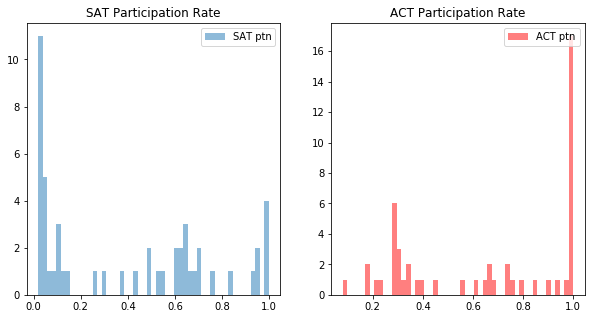

In [17]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.hist(satact.SATPTN, bins=51, alpha=0.5, label='SAT ptn')
plt.title('SAT Participation Rate')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(satact.ACTPTN, bins=51, alpha=0.5, label='ACT ptn', color = 'r')
plt.title('ACT Participation Rate')
plt.legend(loc='upper right')

plt.show()

Histograms of the math sections. 

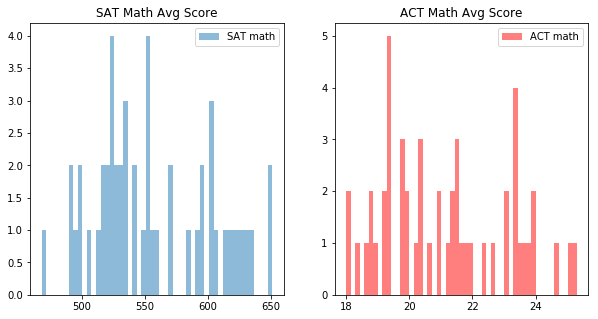

In [18]:
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.hist(satact.SATMATH, bins=51, alpha=0.5, label='SAT math')
plt.title('SAT Math Avg Score')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(satact.ACTMATH, bins=51, alpha=0.5, label='ACT math', color = 'r')
plt.title('ACT Math Avg Score')
plt.legend(loc='upper right')

plt.show()

Histograms of the non math or science sections. 

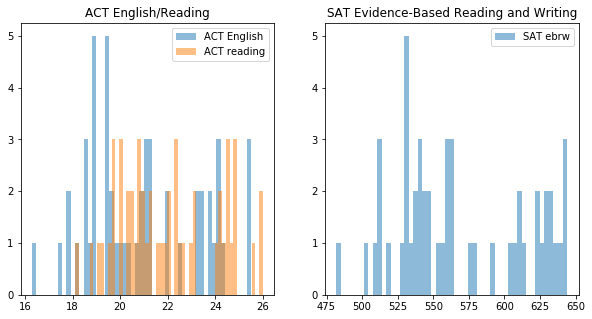

In [19]:
x = [satact.ACTENG]
y = [satact.ACTREAD]

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.hist(x, bins=51, alpha=0.5, label='ACT English')
plt.hist(y, bins=51, alpha=0.5, label='ACT reading')
plt.title('ACT English/Reading')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.hist(satact.SATEBRW, bins=51, alpha=0.5, label='SAT ebrw')
plt.title('SAT Evidence-Based Reading and Writing')
plt.legend(loc='upper right')

plt.show()

In [20]:
satact.head(1)

,ST,SATPTN,SATEBRW,SATMATH,SATTOT,ACTPTN,ACTENG,ACTMATH,ACTREAD,ACTSCI,ACTCOMP
0,Alabama,0.05,593.0,572.0,1165.0,1.0,18.9,18.4,19.7,19.4,19.2


Looking at the correlations between variables. 

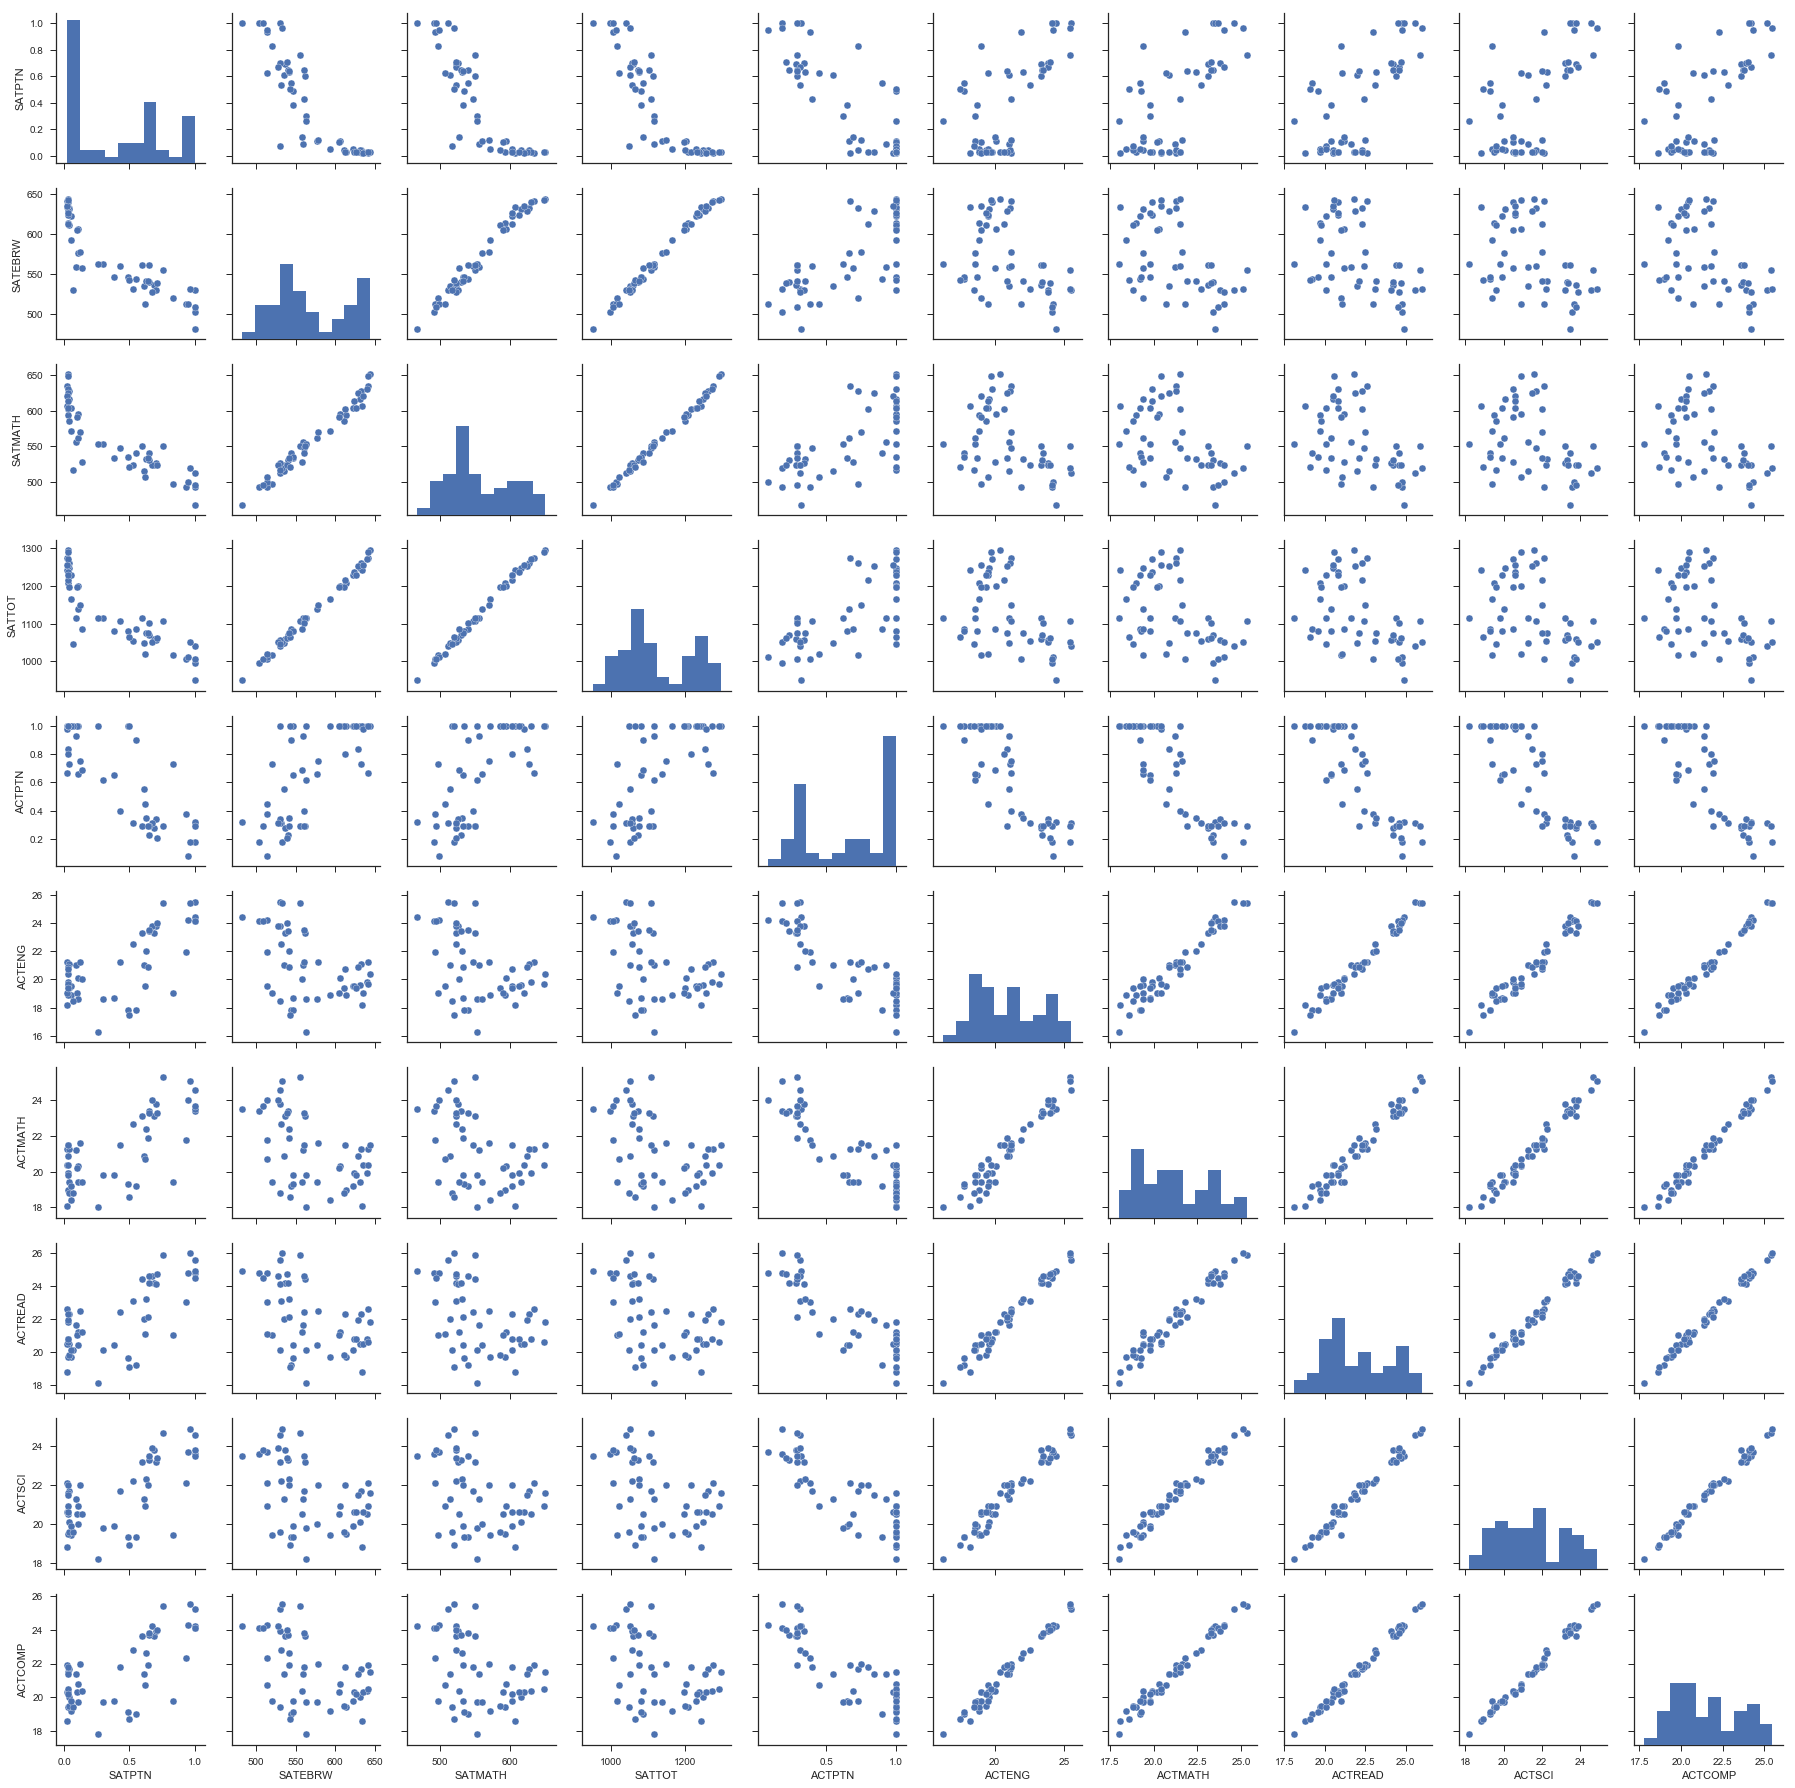

In [21]:
import seaborn as sns
sns.set_palette("husl")
sns.set(style="ticks", color_codes=True)
sns.pairplot(satact)

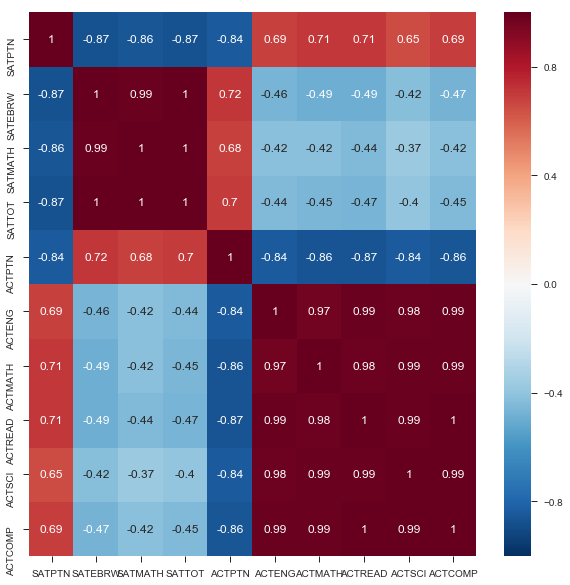

In [22]:
plt.figure(figsize=(10,10))
sns.set_palette("husl")
sns.heatmap(satact.corr(), annot=True);

This heatmap of our data is annoted with the strength of the correlations for all relationships. As described before, we see strong correlation between aptitude across individual tests, e.g., a strong ACT science score is associated with a strong ACT reading score.  

Obviously, there is a strong correlation between doing well in one part of one test and doing well in another part of the same test. What is also interesting to note is that there doesn't seem to be a correlation between sat scores and act scores, as one would expect one. However, the tests are quite different. Finally, there is a correlation, albeit a weaker one, between participation and score. This is a negative correlation, indicating that the higher level of participation a state has, the lower we would expect the average scores to be. Unfortunately, we would expect this to be a causal relationship from participation to score, not the other way around, and thus does not help us in our quest to increase participation. There also seems to be a negative correlation between ACT participation and SAT participation, again, which we would expect. However, this might help us in our plan to increase SAT participation. 

Now, some further visualizations. 

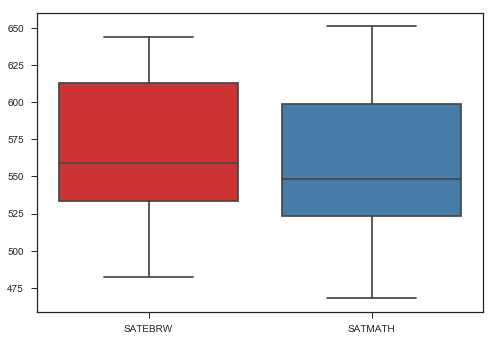

In [23]:
ax = sns.boxplot(data=satact[['SATEBRW', 'SATMATH']], palette="Set1")

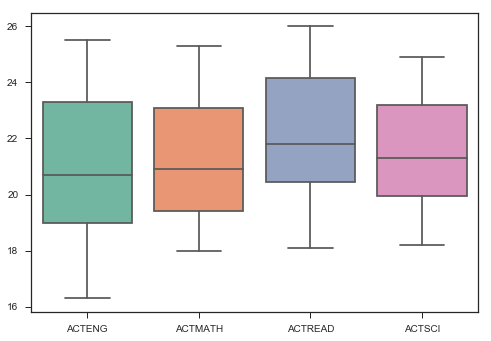

In [24]:
ax = sns.boxplot(data=satact[['ACTENG',
       'ACTMATH', 'ACTREAD', 'ACTSCI']], palette="Set2")

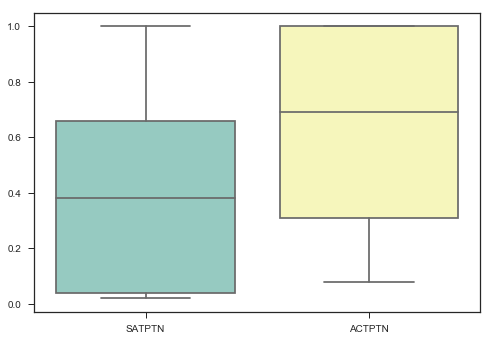

In [25]:
ax = sns.boxplot(data=satact[['SATPTN', 'ACTPTN']], palette="Set3")

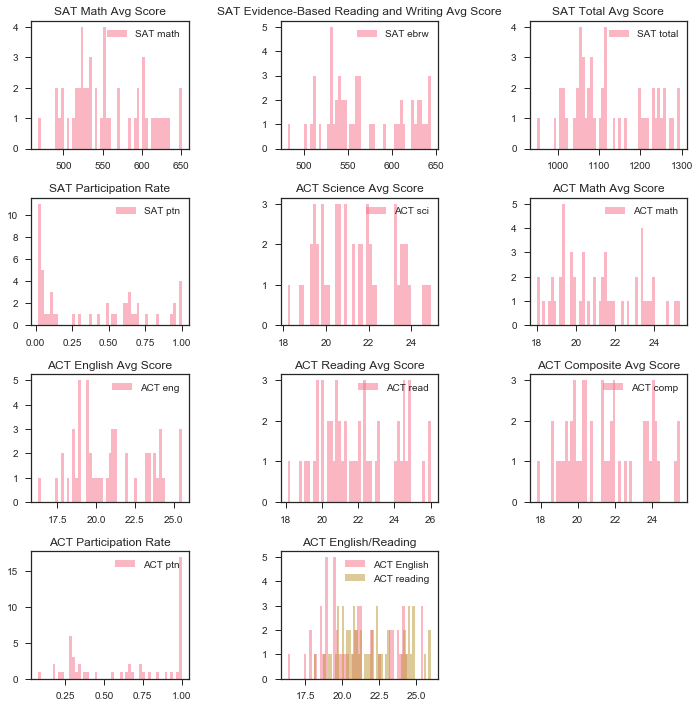

In [26]:
plt.figure(figsize=(10,10));

plt.subplot(4, 3, 1);
plt.hist(satact.SATMATH, bins=51, alpha=0.5, label='SAT math');
plt.title('SAT Math Avg Score');
plt.legend(loc='upper right');

plt.subplot(4, 3, 2);
plt.hist(satact.SATEBRW, bins=51, alpha=0.5, label='SAT ebrw');
plt.title('SAT Evidence-Based Reading and Writing Avg Score');
plt.legend(loc='upper right');

plt.subplot(4, 3, 3);
plt.hist(satact.SATTOT, bins=51, alpha=0.5, label='SAT total');
plt.title('SAT Total Avg Score');
plt.legend(loc='upper right');

plt.subplot(4, 3, 4);
plt.hist(satact.SATPTN, bins=51, alpha=0.5, label='SAT ptn');
plt.title('SAT Participation Rate');
plt.legend(loc='upper right');

plt.subplot(4, 3, 5);
plt.hist(satact.ACTSCI, bins=51, alpha=0.5, label='ACT sci');
plt.title('ACT Science Avg Score');
plt.legend(loc='upper right');

plt.subplot(4, 3, 6);
plt.hist(satact.ACTMATH, bins=51, alpha=0.5, label='ACT math');
plt.title('ACT Math Avg Score');
plt.legend(loc='upper right');

plt.subplot(4, 3, 7);
plt.hist(satact.ACTENG, bins=51, alpha=0.5, label='ACT eng');
plt.title('ACT English Avg Score');
plt.legend(loc='upper right');

plt.subplot(4, 3, 8);
plt.hist(satact.ACTREAD, bins=51, alpha=0.5, label='ACT read');
plt.title('ACT Reading Avg Score');
plt.legend(loc='upper right');

plt.subplot(4, 3, 9);
plt.hist(satact.ACTCOMP, bins=51, alpha=0.5, label='ACT comp');
plt.title('ACT Composite Avg Score');
plt.legend(loc='upper right');

plt.subplot(4, 3, 10);
plt.hist(satact.ACTPTN, bins=51, alpha=0.5, label='ACT ptn');
plt.title('ACT Participation Rate');
plt.legend(loc='upper right');

plt.subplot(4, 3, 11);
plt.hist(x, bins=51, alpha=0.5, label='ACT English');
plt.hist(y, bins=51, alpha=0.5, label='ACT reading');
plt.title('ACT English/Reading');
plt.legend(loc='upper right');

plt.tight_layout();
plt.show();

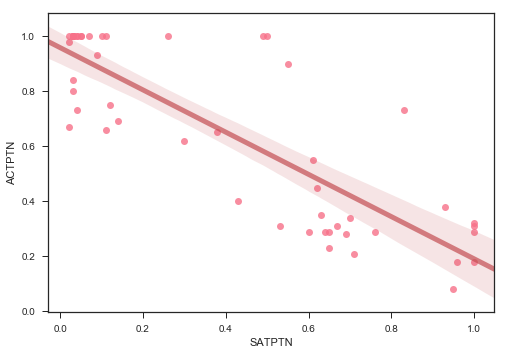

In [29]:
import seaborn as sns
sns.regplot(x=satact['SATPTN'], y=satact['ACTPTN'], line_kws={"color":"r","alpha":0.7,"lw":5})

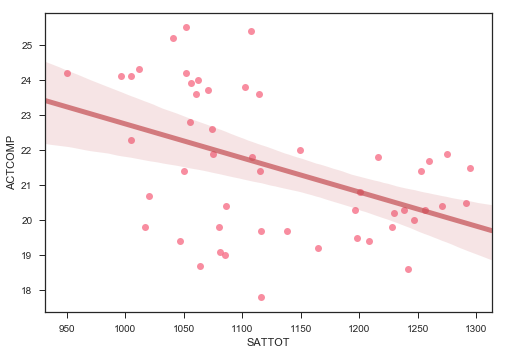

In [30]:
import seaborn as sns
sns.regplot(x=satact['SATTOT'], y=satact['ACTCOMP'], line_kws={"color":"r","alpha":0.7,"lw":5})

Here I did some hypothesis testing. 

H$_{0}$: The mean participation rates are the same.

H$_{A}$: The mean participation rates are not the same. 

$\alpha$: .05

In [27]:
import scipy.stats as stats
result = stats.ttest_ind(satact.ACTPTN, satact.SATPTN)
result.statistic, result.pvalue, result

(3.8085778908170544,
 0.00024134203698662353,
 Ttest_indResult(statistic=3.8085778908170544, pvalue=0.00024134203698662353))

Here, we see that when we compare the sample means of both our participation columns, we get a p of .0002, which is far less than our level of significance, which we set to be .05. Thus, there is only a .02% chance that our test result, 3.8, was due to randomness. Therefore, we have evidence that suggest our null hypothesis should be rejected, and so it seams that the participation rates are different. 

Generate and interpreting 95% confidence intervals for SAT and ACT participation rates.

In [28]:
mean1, sigma1 = satact.ACTPTN.mean(), satact.ACTPTN.std()
mean2, sigma2 = satact.SATPTN.mean(), satact.SATPTN.std()

conf_int1 = stats.norm.interval(alpha=0.95, loc=mean1, scale=sigma1)
conf_int2 = stats.norm.interval(alpha=0.95, loc=mean2, scale=sigma2)
print('The 95% confidence interval for the ACT participation is {}, which means that, out of 100 trials, 95 of them will fall between the bounds of this interval.'.format(conf_int1))
print('The 95% confidence interval for the SAT participation is {}, which means that, out of 100 trials, 95 of them will fall between the bounds of this interval. Note that the lower bound of this interval is less than zero. Thus, we can assume that the true interval is (0.)'.format(conf_int2))

The 95% confidence interval for the ACT participation is (0.02260009176854383, 1.2824979474471425), which means that, out of 100 trials, 95 of them will fall between the bounds of this interval.
The 95% confidence interval for the SAT participation is (-0.29337007176461544, 1.0894485031371646), which means that, out of 100 trials, 95 of them will fall between the bounds of this interval. Note that the lower bound of this interval is less than zero. Thus, we can assume that the true interval is (0.)


That's it for the notebook. If you haven't, please look at the accompanying presentation to see my hypothetical recommendations to The College Board. 